# Basic usage of LSTM

In this exercise, we are using LSTM to predict the BTC price.
Historic price data is downloaded from [yahoo finance](https://finance.yahoo.com/quote/BTC-USD/history/).

## EDA

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-02-28,432.571014,435.683014,423.820007,433.503998,433.503998,53033400
1,2016-02-29,433.437988,441.506989,431.692993,437.696991,437.696991,60694700
2,2016-03-01,437.916992,439.653015,432.319000,435.122986,435.122986,74895800
3,2016-03-02,435.131012,435.916992,423.989014,423.989014,423.989014,74955296
4,2016-03-03,423.911987,425.372986,419.411011,421.651001,421.651001,100484000


In [3]:
print(f'Are there null values? {df.isnull().values.any()}')

Are there null values? False


In [4]:
# change format of 'Date'
df['Date'] = pd.to_datetime(df['Date'])

<AxesSubplot:xlabel='Year', ylabel='Price [$]'>

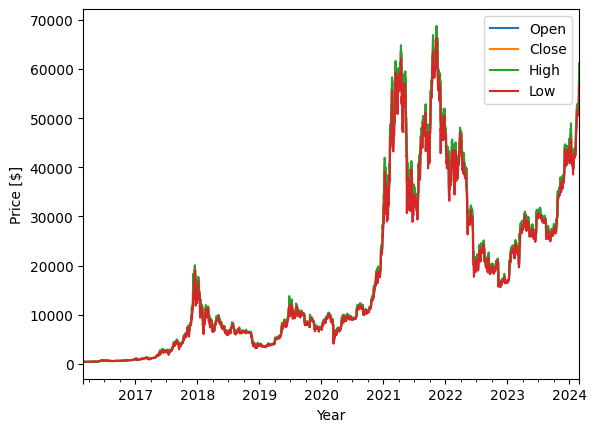

In [25]:
df.plot(x='Date', y=['Open', 'Close', 'High', 'Low'],
        xlabel='Year', ylabel='Price [$]')

We can't see much here.
Let's look at the data from the last year.

In [6]:
# get data for 12 months year
last_year_df = df[df['Date'] > df['Date'].iloc[-1] - pd.Timedelta(365, "day")]
last_year_df.reset_index(drop=True, inplace=True)
last_year_df.set_index('Date', inplace=True)
print(last_year_df.shape)
last_year_df.head()

(365, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-01,23150.929688,23880.632813,23088.626953,23646.550781,23646.550781,24662841200
2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,23475.466797,20386398516
2023-03-03,23476.632813,23479.347656,22213.238281,22362.679688,22362.679688,26062404610
2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,22353.349609,11166012913
2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672,22435.513672,13317001733


In [7]:
max_by_month_df = last_year_df.groupby(pd.Grouper(freq='M')).Close.max().reset_index()
max_by_month_df.set_index('Date', inplace=True)
max_by_month_df.rename(columns={"Close": "Max"}, inplace=True)
max_by_month_df

,Max
Date,
2023-03-31,28478.484375
2023-04-30,30485.699219
2023-05-31,29534.384766
2023-06-30,30695.468750
2023-07-31,31476.048828
2023-08-31,29765.492188
2023-09-30,27211.117188
2023-10-31,34667.781250
2023-11-30,37880.582031


In [8]:
min_by_month_df = last_year_df.groupby(pd.Grouper(freq='M')).Close.min().reset_index()
min_by_month_df.set_index('Date', inplace=True)
min_by_month_df.rename(columns={"Close": "Min"}, inplace=True)
min_by_month_df

,Min
Date,
2023-03-31,20187.244141
2023-04-30,27276.910156
2023-05-31,26334.818359
2023-06-30,25124.675781
2023-07-31,29176.916016
2023-08-31,25931.472656
2023-09-30,25162.654297
2023-10-31,26756.798828
2023-11-30,34732.324219


In [19]:
# extract month out of the date
merged_df = pd.merge(min_by_month_df, max_by_month_df, left_index=True, right_index=True).reset_index()
merged_df['Date'] = merged_df['Date'].dt.month_name()
merged_df.set_index('Date', inplace=True)
merged_df.head()

,Min,Max
Date,,
March,20187.244141,28478.484375
April,27276.910156,30485.699219
May,26334.818359,29534.384766
June,25124.675781,30695.468750
July,29176.916016,31476.048828


<AxesSubplot:title={'center':'Min/Max values by month in the past year'}, xlabel='Month', ylabel='Price [$]'>

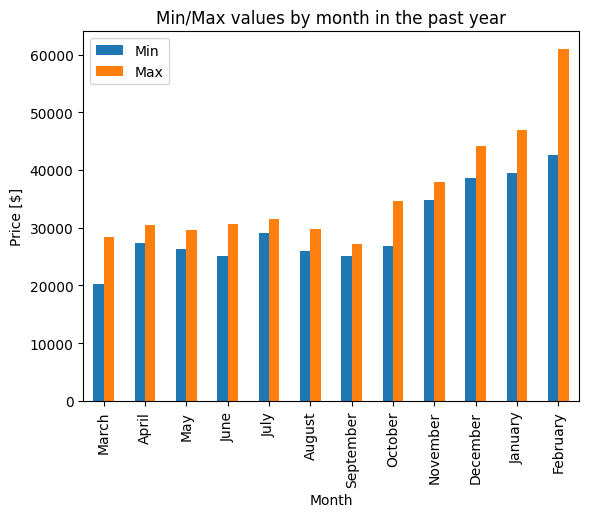

In [22]:
merged_df.plot.bar(y=['Min', 'Max'], use_index=True,
                   ylabel='Price [$]',
                   xlabel='Month',
                   title='Min/Max values by month in the past year')

## Data pre-processing

In this exercise, we will be predicting the next time step (we will focus only on the closing price), based on the current and two previous time step (lookback = 3).
To achieve this, we need to convert our dataset into a supervised learning dataset:

Original Dataset: <br />
Y = [Y0, Y1, Y2, ... YN] <br />

Supervised learning Dataset (lookback=3): <br />
X.shape = (timesteps - lookback) x (lookback) <br />

X = [ <br />
[Y0, Y1, Y2] <br />
[Y1, Y2, Y3] <br />
... <br />
] <br />

Y = [Y3, ... YN] <br />
Y.shape = timesteps - lookback <br />


In [58]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [48]:
# normalize the dataset to be between [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
norm_dataset = scaler.fit_transform(last_year_df['Close'].to_frame())  # df is converted to np array
norm_dataset.shape

(365, 1)

In [49]:
# split into train and test sets
train_size = int(len(last_year_df) * 0.67)
test_size = len(last_year_df) - train_size
norm_train, norm_test = norm_dataset[0:train_size,:], norm_dataset[train_size:len(last_year_df),:]
print(f"Length of training data: {norm_train.shape} and testing data: {norm_test.shape}")

Length of training data: (244, 1) and testing data: (121, 1)


In [50]:
# create the supervised dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3
norm_trainX, norm_trainY = create_dataset(norm_train, look_back)
norm_testX, norm_testY = create_dataset(norm_test, look_back)
print(f"Shape of trainX is: {norm_trainX.shape}, shape of trainY is {norm_trainY.shape}")
print(f"Shape of testX is: {norm_testX.shape}, shape of testY is {norm_testY.shape}")

Shape of trainX is: (241, 3), shape of trainY is (241,)
Shape of testX is: (118, 3), shape of testY is (118,)


In [51]:
# the algorithm requires reshaping the data into a 3D array
# reshape data from [samples, features] to [samples, time steps, features(look back timesteps)]
norm_trainX = np.reshape(norm_trainX, (norm_trainX.shape[0], norm_trainX.shape[1], 1))
norm_testX = np.reshape(norm_testX, (norm_testX.shape[0], norm_testX.shape[1], 1))
print(f"Shape of trainX is: {norm_trainX.shape}, shape of trainY is {norm_trainY.shape}")
print(f"Shape of testX is: {norm_testX.shape}, shape of testY is {norm_testY.shape}")

Shape of trainX is: (241, 3, 1), shape of trainY is (241,)
Shape of testX is: (118, 3, 1), shape of testY is (118,)


## Train/Test LSTM network

In [55]:
# create and fit the LSTM network
# 1 visible layer with 1 input
# 1 hidden layer with 4 LSTM blocks
# 1 output layer predicting 1 value
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(norm_trainX, norm_trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
241/241 - 2s - loss: 6.3060e-04 - 2s/epoch - 7ms/step
Epoch 2/20
241/241 - 0s - loss: 4.1687e-04 - 470ms/epoch - 2ms/step
Epoch 3/20
241/241 - 0s - loss: 3.8862e-04 - 488ms/epoch - 2ms/step
Epoch 4/20
241/241 - 0s - loss: 3.4941e-04 - 467ms/epoch - 2ms/step
Epoch 5/20
241/241 - 0s - loss: 3.5227e-04 - 471ms/epoch - 2ms/step
Epoch 6/20
241/241 - 0s - loss: 3.6885e-04 - 470ms/epoch - 2ms/step
Epoch 7/20
241/241 - 0s - loss: 3.8419e-04 - 471ms/epoch - 2ms/step
Epoch 8/20
241/241 - 0s - loss: 3.7078e-04 - 466ms/epoch - 2ms/step
Epoch 9/20
241/241 - 0s - loss: 3.8648e-04 - 465ms/epoch - 2ms/step
Epoch 10/20
241/241 - 0s - loss: 3.7204e-04 - 468ms/epoch - 2ms/step
Epoch 11/20
241/241 - 0s - loss: 3.5671e-04 - 460ms/epoch - 2ms/step
Epoch 12/20
241/241 - 0s - loss: 3.4965e-04 - 469ms/epoch - 2ms/step
Epoch 13/20
241/241 - 0s - loss: 3.5215e-04 - 461ms/epoch - 2ms/step
Epoch 14/20
241/241 - 0s - loss: 3.6068e-04 - 468ms/epoch - 2ms/step
Epoch 15/20
241/241 - 0s - loss: 3.8536e-04 - 

In [59]:
# make predictions
norm_trainYhat = model.predict(norm_trainX)
norm_testYhat = model.predict(norm_testX)

# invert the scaling
trainYhat = scaler.inverse_transform(norm_trainYhat)
trainY = scaler.inverse_transform(norm_trainY.reshape(-1,1))
testYhat = scaler.inverse_transform(norm_testYhat)
testY = scaler.inverse_transform(norm_testY.reshape(-1,1))

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainYhat))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testYhat))
print('Test Score: %.2f RMSE' % (testScore))

4/4 [==============================] - 0s 40ms/step
Train Score: 724.46 RMSE
Test Score: 1295.16 RMSE


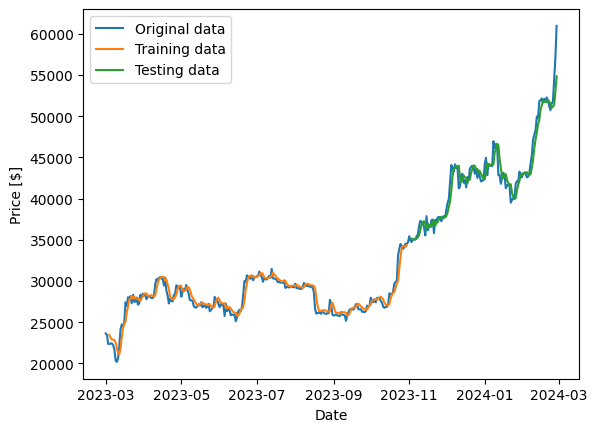

In [69]:
# shift train predictions for plotting
trainYhatPlot = np.ones_like(last_year_df['Close'].to_frame()) * np.nan
trainYhatPlot[look_back:len(trainYhat)+look_back, :] = trainYhat

# shift test predictions for plotting
testYhatPlot = np.ones_like(last_year_df['Close'].to_frame()) * np.nan
testYhatPlot[look_back+len(trainYhat)+look_back:, :] = testYhat

# plot baseline and predictions
plt.plot(last_year_df['Close'].to_frame(), label='Original data')
plt.plot(last_year_df.index, trainYhatPlot, label='Training data')
plt.plot(last_year_df.index, testYhatPlot, label='Testing data')
plt.xlabel('Date')
plt.ylabel('Price [$]')
plt.legend()